# 🐱 基于CNN-RNN的医疗文本生成

本项目使用经过IMAGENET预训练的resnet101网络对图像特征进行提取后，
将图像特征输入LSTM来生成影像的文本描述。
  
初步实现了图像到文本的简单生成。

---

## 📖  0 项目背景

<font size=3 face="仿宋" >

随着近年来深度学习的飞速发展，深度学习在医疗行业展现出巨大的发展潜力。因此，如果能通过深度学习的方法，使用计算机代替医生进行机械的影像报告撰写工作，这样既避免了经验不足的医生在阅片诊断中产生的误诊情况，又使得更多的资深医生可以从繁重的重复性工作中解脱出来，将更多的时间投入病人的诊治中去。
  
医学影像报告自动生成是近年来计算机与医疗图像新兴的交叉方向之一。目前，影像报告自动生成模型主要借鉴了机器翻译领域的 Encoder-Decoder 框架，利用卷积
神经网络（Convolutional Neural Network, CNN）对图像特征进行提取进而利用循环神经网络（Recurrent Neural Network, RNN）来生成影像的文本描述


</font>

## 📌  1 数据集

<font size=3 face="仿宋" >
  
印第安纳大学胸部 X 射线集合 (IU X 射线) 是一组胸部 X 射线图像及其相应的诊断报告。该数据集包含 7,470 对图像和报告（6470：500：500）。 每个报告由以下部分组成：印象、发现、标签、比较和指示。平均每张图像关联2.2个标签，5.7个句子，每个句子包含6.5个单词。

![](https://ai-studio-static-online.cdn.bcebos.com/8f2df85130804304a3a854bc8b2fa8231b01a6c1f61a485fa80e8d305c8efead)

> 本项目仅使用FINDINGS部分作为图像生成标签

</font>

参考代码：

* https://github.com/chenyuntc/pytorch-book/tree/master/chapter10-image_caption

## 🐰 2 数据集生成

### 🐅 2.1  医疗文本CSV生成
---

<font size=3 face="仿宋">
  
解压原始数据，对xml格式的数据进行解析，提取图像文件名和对应的FINDINGS，并生成CSV文件。

</font>

In [1]:
# 解压数据集
!unzip  -o  data/data123482/IU数据集.zip -d /home/aistudio/work/

In [2]:
# 取消警告的输出
import warnings
warnings.filterwarnings("ignore")

In [3]:
## 制作CSV数据集
# 平均字符数为 31.64992700729927
import os
import glob
import pandas as pd
from xml.dom import minidom
import re
import numpy as np
LENGTH = []

def EmptyDrop(data):
    for i in range(len(data)):
        if data.loc[i,'dir'] ==[] or data.loc[i,'caption'] ==[]:
            #如果为空，则删除该行
            data.drop([i],axis = 0,inplace = True) 
        else:
            data.loc[i,'dir'] = data.loc[i,'dir'][0]
            data.loc[i,'caption'] = data.loc[i,'caption'][0]
    data.reset_index(drop = True,inplace = True)
    return data

def clean_text(origin_text):
    # 去掉标点和非法字符
    text = re.sub("^a-zA-Z"," ",origin_text)
    #大写改小写
    cleaned_text = text.lower()
    return cleaned_text
def xml2csv(path):
    num = 0
    column_name = ['dir','caption']
    xml_csv = pd.DataFrame(columns = column_name)
    #图片保存地址
    pic_path =  'work/IU数据集/NLMCXR_png'
    for xml_file in glob.glob(path+'/*.xml'):

        #记录每个xml需要保存的所有信息 fx 地址 IMPRESSION FINDINGS 
        xml_list = []
        #打开xml文档
        dom = minidom.parse(xml_file)
        #得到文档元素对象
        root = dom.documentElement
        # f1 地址
        itemlists=root.getElementsByTagName('parentImage')
        #记录地址
        dirAll = []
        for itemlist in itemlists:
            figureId=itemlist.getElementsByTagName('figureId')
            #找出该图片的figureID
            figure = figureId[0].childNodes[0].nodeValue
            #找出该图片的名称
            ID= itemlist.getAttribute('id')
            IdPath = ID
            #正面图&侧面图
            figurePath = [figure+' '+IdPath]
            dirAll.extend(figurePath)
        xml_list.append(dirAll)

        #记录FINDINGS and IMPRESSION
        #记录内容
        CaptionAll = []
        itemlists=root.getElementsByTagName('AbstractText')
        for i in range(len(itemlists)):
            Label= itemlists[i].getAttribute('Label')
            if Label == 'FINDINGS': # or Label == 'IMPRESSION':
                # 内容不为空
                if len(itemlists[i].childNodes)!=0:
                    text = itemlists[i].childNodes[0].nodeValue
                    #转小写,过滤无效字符
                    text = clean_text(text)
                    text = text.replace('.','')
                    text = text.replace(',','')
                    text = [text+'']                    
                    CaptionAll.extend(text)
        if len(CaptionAll)>=1:
            LENGTH.append(len(CaptionAll[0].split(' ')))
        xml_list.append(CaptionAll)
        xml_csv.loc[num] = [item for item in xml_list]
        num = num + 1
        print('epoch[{}/{}]'.format(num,len(glob.glob(path+'/*.xml'))))
   # print(np.mean(LENGTH))
    return xml_csv

def main():
    xml_path = os.path.join('work','IU数据集','NLMCXR_reports','ecgen-radiology')
    csv = xml2csv(xml_path)
    csv1 = EmptyDrop(csv)
    csv1.to_csv('work/IUxRay.csv',index=None)
    
if __name__ == '__main__':
    main()


### 🐅 2.2 图像特征提取
---

<font size=3 face="仿宋">
  
* 使用ImageNet预训练的resnet101模型提取图像特征（删除最后的全连接层，改为恒等映射）。
  
* 将数据保存为h5文件
  
</font>

In [4]:
## 使用resnet101预训练模型提取图像特征
import paddle
from paddle.vision.models import resnet101
import h5py
import cv2

csv_file = pd.read_csv('work/IUxRay.csv')
h5_png_file =list(csv_file['dir'])

# 创建保存目录
save_path = 'work/util_IUxRay'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 导入模型resnet101 使用谷歌预训练
model = resnet101(pretrained=True)
# 删除最后的全连接层
del model.fc
model.fc = lambda x:x

h5f = h5py.File(os.path.join(save_path,'resnet101_festures.h5'), 'w')

for idx,item in enumerate(h5_png_file):
    # 读取所有PNG（F1,F2...）
    print(idx,len(h5_png_file))
    item_all = item.split(',')
    for item_t in item_all:
        item_t = item_t.replace('\'','').replace('[','').replace(']','')
        # 对不同朝向的图进行区分
        for orie in ['F1','F2','F3','F4']:
            if orie in item_t:
                orie_fin = orie
                item_fin = item_t.replace(orie,'').replace(' ','')
                item_fin_png = item_fin + '.png'
                print(orie_fin + '_' + item_fin)
                # 读取文件送入模型提取特征并保存为h5
                img = cv2.imread(os.path.join('work/IU数据集/NLMCXR_png',item_fin_png))
                # BGR转RGB，且HWC转CHW
                img = img[:,:,::-1].transpose((2,0,1))
                # 扩展维度
                img = np.expand_dims(img, 0)
                img_tensor = paddle.to_tensor(img,dtype='float32' ,place=paddle.CUDAPinnedPlace())
                # 进行特征提取
                out = model(img_tensor)
                data = out.numpy().astype('float32')
                # 保存的数据为h5
                save_path_h5 = data[0]
                h5f.create_dataset(orie_fin + '_' + item_fin, data=save_path_h5)
h5f.close()


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/h5py/__init__.py:36: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
100%|██████████| 263160/263160 [00:10<00:00, 23946.85it/s]


0 3337
F1_CXR646_IM-2225-1001


RuntimeError: (PermissionDenied) Cannot use CUDAPinnedPlace in CPU only version, Please recompile or reinstall Paddle with CUDA support. (at /paddle/paddle/fluid/pybind/pybind.cc:1764)


In [ ]:
# 读取h5文件
import h5py
h5f = h5py.File('work/util_IUxRay/resnet101_festures.h5','r')
data = h5f['F1_CXR3027_IM-1402-1001'] # 第一个下划线 之前为图片朝向，之后为图像原命名
print(np.array(data).shape) # 每个图片保存为一个2048维度的向量
h5f.close() 

### 🐅 2.3 字典生成
---

<font size=3 face="仿宋">
  
* 统计训练数据，按照单词进行分割创建字典。
  
* 字典修正：删除仅在数据集中出现过一次的单词
  
</font>

In [ ]:
# 统计训练数据，以单词为粒度创建字典
import pandas as pd
import numpy as np
import re

csv_file = pd.read_csv('work/IUxRay.csv')
csv_file.head()

CaptionWordAll = []
CaptionWordLength = []
for idx,data_ in enumerate(csv_file.iterrows()):
    caption = data_[1][1]
    CaptionWordLength.append(len(caption.split(' ')))
    CaptionWordAll.extend(caption.split(' '))

print('平均句子长度为：',np.mean(CaptionWordLength))
print('最大句子长度为：',np.max(CaptionWordLength))
print('最小句子长度为：',np.min(CaptionWordLength))

print('单词总量为：',len(CaptionWordAll))
print('字典长度为：',len(set(CaptionWordAll)))

# 100

from collections import Counter
# 统计频率，按照从高到底排序，这样构建的字典使用频率最高的符号在最前面，查找起来快
counts = Counter(CaptionWordAll)
count_sorted = counts.most_common()
count_sorted_ = {k: v for k, v in count_sorted if v > 1}

# 构造字典
# 增加 <pad> 0 <unk> 1 <start> 2 <end> 3  四个作为常用符号

word2id_dict={'<pad>':0,'<unk>':1,'<start>':2,'<end>':3}
id2word_dict={0:'<pad>',1:'<unk>',2:'<start>',3:'<end>'}

for idx,item in enumerate(count_sorted_):
    idx_ = idx+4 # 预留四个做为记录
    item_ = item
    word2id_dict[item_] = idx_
    id2word_dict[idx_] = item_

# 删除只出现一次的单词
print('修正后字典长度为：',len(word2id_dict))


平均句子长度为： 31.45519928079113
最大句子长度为： 173
最小句子长度为： 7
单词总量为： 104966
字典长度为： 1754
修正后字典长度为： 1151


## 🥝 3 定义数据读取类
---

<font size=3 face="仿宋">
  
* 将数据按照8：2划分为训练集和验证集。
  
* 将文本数据经过字典进行映射，不同于翻译任务，本任务用图像特征替代了<start>（85行）。
  
</font>

In [ ]:
## 完成dataload

import paddle
from paddle.io import Dataset
import numpy as np
from sklearn.model_selection import train_test_split

# 重写数据读取类
class CaptionDataset(Dataset):
    # 构造函数，定义函数参数
    def __init__(self,csvData,word2id_dict,h5f,maxlength = 40,mode = 'train'):
        self.mode = mode
        self.w2i_dict = word2id_dict
        self.maxlength = maxlength # 输入的最长字符数
        self.padid = 0 # 0为填充符号
        self.h5f = h5f
        # 根据train/test 将数据按比例处理
        train,test =csvData.iloc[:int(0.8*len(csvData)),:],csvData.iloc[int(0.8*len(csvData)):,:] #train_test_split(csvData,train_size=0.8,random_state=10)

        if self.mode == 'train':
            train.reset_index(drop=True)
            self.data = train
        else:
            test.reset_index(drop=True)
            self.data = test

    # 实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
    def __getitem__(self, index):

        path_name, trg_  = self.data.iloc[index,:]
        
        # 读取图像的特征
        temp  = path_name.split(' ')
        names = '_'.join(temp)
        img_feature = np.array(self.h5f[names]) # 第一个下划线 之前为图片朝向，之后为图像原命名

        # 输入转成idx
        trg,trg_length = self.generIdxList(trg_) # data
        img_name = temp[-1]
        return img_feature,trg,trg_length,img_name# 特征，

    # 实现__len__方法，返回数据集总数目
    def __len__(self):
        return len(self.data)
    
    def generIdxList(self,tdata):
        # 从输入的String中，生成idx的List
        data = tdata.split(' ')
        data_out = []
        # 限制长度，输入'<start>' 和 '<end>'
        data = ['<start>'] + data 
        
        if len(data)>self.maxlength-1:
            data = data[:self.maxlength-1] # 留一个位置给'<end>
            data = data + ['<end>']

        else:
            # 占位符
            occupy_ = ['<pad>'] * (self.maxlength - 1 - len(data))
            data = data + ['<end>']
            data = data + occupy_

        # word 2 index
        for word in data:

            if self.w2i_dict.get(word)!= None: # 能找到word
                id_ = self.w2i_dict[word]
                data_out.append(id_)
            else:
                id_ = self.w2i_dict['<unk>']
                data_out.append(id_)

        length = len(data_out)-1

        return data_out,length

def stackInput(inputs):

    img_features = np.stack([inputsub[0] for inputsub in inputs], axis=0)
    trg = np.stack([inputsub[1] for inputsub in inputs], axis=0)
    trg_length = np.stack([inputsub[2] for inputsub in inputs], axis=0)


    trg_mask =(trg[:,:-1]!=0).astype(paddle.get_default_dtype())
    trg_ = trg[:,1:] # 将start标记更改为 imgfeatures
    return img_features,trg_length,trg_[:,:-1],trg[:,1:,np.newaxis],trg_mask

In [ ]:
# 测试数据读取
import pandas as pd
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
csvData = pd.read_csv('work/IUxRay.csv')
h5f = h5py.File('work/util_IUxRay/resnet101_festures.h5','r')

maxlength = 40

dataset=CaptionDataset(csvData,word2id_dict,h5f,maxlength,'train')
data_loader = paddle.io.DataLoader(dataset, batch_size=1,collate_fn = stackInput, shuffle=False)

for item in data_loader:
    print(item[0].shape,item[1].shape,item[2].shape,item[3].shape,item[4].shape)
    break

[1, 2048] [1] [1, 38] [1, 39, 1] [1, 39]


## 💡 4 定义模型
---

<font size=3 face="仿宋">
  
* 定义LSTM模型用于文本生成
  
* 定义beam search算法对生成结果进行优化
  
</font>

In [ ]:
# 定义模型
import paddle.nn as nn
import paddle
class CaptionModel(paddle.nn.Layer):

    def __init__(self, vocab_size,embedding_dim,hidden_size,num_layers,word2id_dict,id2word_dict):
        
        super(CaptionModel,self).__init__()

        self.hidden_size=hidden_size
        self.num_layers=num_layers        
        self.fc = paddle.nn.Linear(2048,embedding_dim)
        self.embedding=paddle.nn.Embedding(vocab_size,embedding_dim)
        self.rnn=paddle.nn.LSTM(input_size=embedding_dim,
                                hidden_size=hidden_size,
                                num_layers=num_layers)
        self.word2ix = word2id_dict
        self.ix2word = id2word_dict
        self.classifier = paddle.nn.Linear(hidden_size,vocab_size)

    def forward(self,img_features,trg,trg_length):
        img_features = paddle.unsqueeze(self.fc(img_features),axis = 1)
        embeddings = self.embedding(trg)
        inputs = paddle.concat([img_features,embeddings],axis = 1)
        outputs,state = self.rnn(inputs,sequence_length  = trg_length)
        predict = self.classifier(outputs)

        return predict

    def generate(self, img_feat, eos_token='<end>',
                 beam_size=2,
                 max_caption_length=40,
                 length_normalization_factor=0.0):
        """
        根据图片生成描述,主要是使用beam search算法以得到更好的描述
        """
        cap_gen = CaptionGenerator(embedder=self.embedding,
                                   rnn=self.rnn,
                                   classifier=self.classifier,
                                   eos_id=self.word2ix[eos_token],
                                   beam_size=beam_size,
                                   max_caption_length=max_caption_length,
                                   length_normalization_factor=length_normalization_factor)

        img_feat = paddle.unsqueeze(img_feat,axis = 0)
        img = paddle.unsqueeze(self.fc(img_feat),axis = 0)

        sentences, score = cap_gen.beam_search(img)

        sentences = [' '.join([self.ix2word[int(idx)] for idx in sent])
                     for sent in sentences]
        return sentences

In [ ]:
# Beam Search
import paddle.nn as nn
import heapq

class TopN(object):
    """Maintains the top n elements of an incrementally provided set."""

    def __init__(self, n):
        self._n = n
        self._data = []

    def size(self):
        assert self._data is not None
        return len(self._data)

    def push(self, x):
        """Pushes a new element."""
        assert self._data is not None
        if len(self._data) < self._n:
            heapq.heappush(self._data, x)
        else:
            heapq.heappushpop(self._data, x)

    def extract(self, sort=False):
        """
        Extracts all elements from the TopN. This is a destructive operation.
        The only method that can be called immediately after extract() is reset().
        Args:
          sort: Whether to return the elements in descending sorted order.
        Returns:
          A list of data; the top n elements provided to the set.
        """
        assert self._data is not None
        data = self._data
        self._data = None
        if sort:
            data.sort(reverse=True)
        return data

    def reset(self):
        """Returns the TopN to an empty state."""
        self._data = []

class Caption(object):
    """Represents a complete or partial caption."""

    def __init__(self, sentence, state, logprob, score, metadata=None):
        """Initializes the Caption.
        Args:
          sentence: List of word ids in the caption.
          state: Model state after generating the previous word.
          logprob: Log-probability of the caption.
          score: Score of the caption.
          metadata: Optional metadata associated with the partial sentence. If not
            None, a list of strings with the same length as 'sentence'.
        """
        self.sentence = sentence
        self.state = state
        self.logprob = logprob
        self.score = score
        self.metadata = metadata

    def __cmp__(self, other):
        """Compares Captions by score."""
        assert isinstance(other, Caption)
        if self.score == other.score:
            return 0
        elif self.score < other.score:
            return -1
        else:
            return 1

    # For Python 3 compatibility (__cmp__ is deprecated).
    def __lt__(self, other):
        assert isinstance(other, Caption)
        return self.score < other.score

    # Also for Python 3 compatibility.
    def __eq__(self, other):
        assert isinstance(other, Caption)
        return self.score == other.score

class CaptionGenerator(object):
    """Class to generate captions from an image-to-text model."""

    def __init__(self,
                 embedder,
                 rnn,
                 classifier,
                 eos_id,
                 beam_size=3,
                 max_caption_length=100,
                 length_normalization_factor=0.0):
        """Initializes the generator.
        Args:
          model: recurrent model, with inputs: (input, state) and outputs len(vocab) values
          beam_size: Beam size to use when generating captions.
          max_caption_length: The maximum caption length before stopping the search.
          length_normalization_factor: If != 0, a number x such that captions are
            scored by logprob/length^x, rather than logprob. This changes the
            relative scores of captions depending on their lengths. For example, if
            x > 0 then longer captions will be favored.
        """
        self.embedder = embedder
        self.rnn = rnn
        self.classifier = classifier
        self.eos_id = eos_id
        self.beam_size = beam_size
        self.max_caption_length = max_caption_length
        self.length_normalization_factor = length_normalization_factor

    def beam_search(self, rnn_input, initial_state=None):
        """Runs beam search caption generation on a single image.
        Args:
          initial_state: An initial state for the recurrent model
        Returns:
          A list of Caption sorted by descending score.
        """

        def get_topk_words(embeddings, state):
            output, new_states = self.rnn(embeddings, state)
            output = self.classifier(paddle.squeeze(output,axis=0))
            logprobs = nn.functional.log_softmax(output, axis=-1)

            if len(logprobs.shape) == 3:
                logprobs = paddle.squeeze(logprobs)
            logprobs, words = logprobs.topk(self.beam_size, 1)
            return words, logprobs, new_states

        partial_captions  = TopN(self.beam_size)
        complete_captions = TopN(self.beam_size)

        words, logprobs, new_state = get_topk_words(rnn_input, initial_state)

        for k in range(self.beam_size):
            cap = Caption(
                sentence=[words[0, k]],
                state=new_state,
                logprob=logprobs[0, k],
                score=logprobs[0, k])

            partial_captions.push(cap)

        # Run beam search.

        for _ in range(self.max_caption_length - 1):
            partial_captions_list = partial_captions.extract()
            partial_captions.reset()
            input_feed =[c.sentence[-1] for c in partial_captions_list]

            input_feed = paddle.to_tensor(input_feed)
            state_feed = [c.state for c in partial_captions_list]
            if isinstance(state_feed[0], tuple):
                state_feed_h, state_feed_c = zip(*state_feed)
                state_feed = (paddle.concat(state_feed_h, 1),
                              paddle.concat(state_feed_c, 1))
            else:
                state_feed = paddle.concat(state_feed, 1)
            

            embeddings = self.embedder(input_feed)

            words, logprobs, new_states = get_topk_words( 
                embeddings, state_feed)
                
            for i, partial_caption in enumerate(partial_captions_list):
                if isinstance(new_states, tuple):
                    state = (paddle.slice(new_states[0],axes=[1],starts=[i],ends = [i+1]),
                             paddle.slice(new_states[1],axes=[1],starts=[i],ends = [i+1]))
                else:
                    state = new_states[i]
                for k in range(self.beam_size):
                    w = words[i, k]
                    sentence = partial_caption.sentence + [w]
                    logprob = partial_caption.logprob + logprobs[i, k]
                    score = logprob
                    if w == self.eos_id:
                        if self.length_normalization_factor > 0:
                            score /= len(sentence)**self.length_normalization_factor
                        beam = Caption(sentence, state, logprob, score)
                        complete_captions.push(beam)
                    else:
                        beam = Caption(sentence, state, logprob, score)
                        partial_captions.push(beam)
            if partial_captions.size() == 0:
                # We have run out of partial candidates; happens when beam_size
                # = 1.
                break

        # If we have no complete captions then fall back to the partial captions.
        # But never output a mixture of complete and partial captions because a
        # partial caption could have a higher score than all the complete
        # captions.
        if not complete_captions.size():
            complete_captions = partial_captions

        caps = complete_captions.extract(sort=True)

        return [c.sentence for c in caps], [c.score for c in caps]


## 🥝 5 定义损失函数
---

<font size=3 face="仿宋">
  
* 使用基本的交叉熵损失函数
  
* 使用定义的trg_mask避免对padding部分求loss
  
</font>

In [ ]:
# 定义损失函数
class CrossEntropy(paddle.nn.Layer):
    def __init__(self):
        super(CrossEntropy,self).__init__()

    def forward(self,pre,real,trg_mask):

        cost=paddle.nn.functional.softmax_with_cross_entropy(logits=pre,label=real)
        
        # 删除axis=2 shape上为1的维度
        cost=paddle.squeeze(cost,axis=[2])
        
        # trg_mask 的形状[batch_size,suqence_len]
        masked_cost=cost*trg_mask
        
        return paddle.mean(paddle.mean(masked_cost,axis=[0]))


## 🦃 6 定义参数并训练
---

<font size=3 face="仿宋">
  
* 增加困惑度作为评价指标
  
* 设置训练参数
  
</font>

In [ ]:
# 参数
import h5py

epochs=60
word_size = 1151
eos_id=word2id_dict['<end>']
num_layers=32
hidden_size=512
embedding_dim=512
lr=1e-3
maxlength=40
model_path='./output'

csvData = pd.read_csv('work/IUxRay.csv')
h5f = h5py.File('work/util_IUxRay/resnet101_festures.h5','r')


In [ ]:
import paddlenlp

model=CaptionModel(word_size,embedding_dim,hidden_size,num_layers,word2id_dict,id2word_dict)

optimizer=paddle.optimizer.Adam(learning_rate=lr,parameters=model.parameters())
# 困惑度
ppl_metric=paddlenlp.metrics.Perplexity()


train_dataset=CaptionDataset(csvData,word2id_dict,h5f,maxlength,'train')
train_loader = paddle.io.DataLoader(train_dataset, batch_size=128,collate_fn = stackInput, shuffle=True)

val_dataset=CaptionDataset(csvData,word2id_dict,h5f,maxlength,'test')
val_loader = paddle.io.DataLoader(val_dataset, batch_size=64,collate_fn = stackInput, shuffle=True)


# 设置优化器
optimizer=paddle.optimizer.Adam(learning_rate=lr,parameters=model.parameters())
# 设置损失函数
loss_fn = CrossEntropy()

perplexity = paddlenlp.metrics.Perplexity()

model.train()

for epoch in range(epochs):
    for batch_id, data in enumerate(train_loader()):

        img_features,trg_length,inputs,label,label_mask = data[0],data[1],data[2],data[3], data[4]  # 数据

        predicts = model(img_features,inputs,trg_length)    # 预测结果

        # 计算损失 等价于 prepare 中loss的设置
        loss = loss_fn(predicts, label , label_mask)

        # 计算困惑度 等价于 prepare 中metrics的设置
        correct = perplexity.compute(predicts, label)
        perplexity.update(correct.numpy())
        ppl = perplexity.accumulate()
        
        # 下面的反向传播、打印训练信息、更新参数、梯度清零都被封装到 Model.fit() 中

        # 反向传播
        loss.backward()

        if (batch_id+1) % 20 == 0:
            print("epoch: {}, batch_id: {}, loss is: {}, ppl is: {}".format(epoch+1, batch_id+1, loss.item(), ppl))

            # 保存模型参数，文件名为Unet_model.pdparams
            paddle.save(model.state_dict(), 'work/LSTM_model.pdparams')

        # 更新参数
        optimizer.step()

        # 梯度清零
        optimizer.clear_grad()

In [ ]:

model.eval()

for batch_id, data in enumerate(val_loader()):

    img_features,trg_length,inputs,label,label_mask = data[0],data[1],data[2],data[3], data[4]  # 数据

    predicts = model(img_features,inputs,trg_length)    # 预测结果

    # 计算损失 等价于 prepare 中loss的设置
    loss = loss_fn(predicts , label , label_mask)

    # 计算困惑度 等价于 prepare 中metrics的设置
    correct = perplexity.compute(predicts, label)
    perplexity.update(correct.numpy())
    ppl = perplexity.accumulate()
    
    # 下面的反向传播、打印训练信息、更新参数、梯度清零都被封装到 Model.fit() 中

    if (batch_id+1) % 1 == 0:
        print(" batch_id: {}, loss is: {}, ppl is: {}".format( batch_id+1, loss.item(), ppl))



## 🍓 7 模型推理



668it [04:45,  2.34it/s]


预测结果： the heart is normal in size no within normal normal no no are are no no no no no <end>
正确结果： the heart size and pulmonary vascularity appear within normal limits the lungs are free of focal airspace disease no pleural effusion or pneumothorax is seen
BLEU: 0.008670173413668955


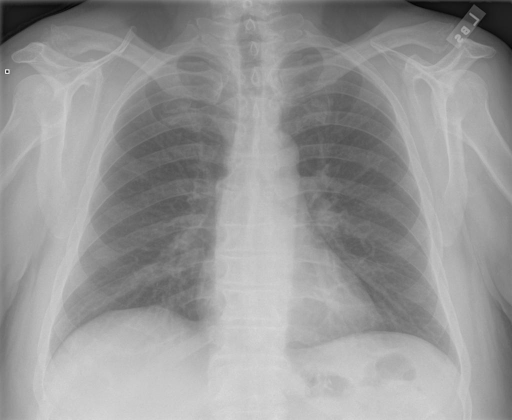

2

In [23]:

# 验证数据集
from IPython.display import display
from PIL import Image
import numpy as np
from tqdm import tqdm

path = 'work/IU数据集/NLMCXR_png/'
csvData = pd.read_csv('work/IUxRay.csv')
h5f = h5py.File('work/util_IUxRay/resnet101_festures.h5','r')
data = csvData.iloc[int(0.8*len(csvData)):,:]
scores = []

Beam_Size = 3
for idx,data_ in tqdm(enumerate(data.iterrows())):
    F_name = data_[1][0]
    F_text = data_[1][1]

    img_name = F_name.split(' ')[-1]
    h5f_name = '_'.join(F_name.split(' '))
    img_feature = np.array(h5f[h5f_name])
    img_path = path + img_name + '.png'
    
    img_feature = paddle.to_tensor(img_feature)
    results = model.generate(img_feature,beam_size=Beam_Size)

    #print('预测结果：',results[Beam_Size-1])
    #print('正确结果：',F_text)

    #img = Image.open(img_path).convert('RGB')
    #display(img, Image.BILINEAR)
    
    # 计算BLUE
    from nltk.translate.bleu_score import sentence_bleu
    reference = [F_text.split(' ')]
    candidate = results[Beam_Size-1].split(' ')
    score = sentence_bleu(reference,candidate)
    scores.append(score)

print('预测结果：',results[Beam_Size-1])
print('正确结果：',F_text)
print('BLEU:',np.mean(scores))
img = Image.open(img_path).convert('RGB')
display(img, Image.BILINEAR)

## 🎖️ 8 项目总结


* >项目主要使用CNN+RNN的形式对CT影像报告的生成进行演示。

* >~~由于BeamSearch的部分代码有小bug，目前使用的实际上是最大概率~~ 已修正，可以正常传入Beam Size参数

* >该项目是ImageCaption任务在医疗文本领域的简单实现，

* >本项目所有代码及数据均以notebook呈现，简单易懂。

* >本项目使用BLUE进行效果评价

- - - -

<font size=3 face="幼圆">
  
**特别注意**：该项目灵感来自《深度学习框架Pytorch入门与实践》第十章内容。
  
</font>

- - - -
  
    有任何问题，欢迎评论区留言交流。

